# 0. Install and Import Dependencies

In [ ]:
import os
import glob
import cv2 as cv
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

# 1. Loading a Video and Saving Frames in Sequences

In [ ]:
# Classes: 3 subfolders within 'Single_person_violent' => Kicking, Punching, Non-violent
CLASSES = ["Kicking", "Punching", "Standing"]

# We will define a fixed sequence length to handle variable-length videos
MAX_SEQ_LEN = 5  

# Set how many frames to skip when reading a video (to reduce computational load)
SKIP_RATE = 1  # example: capture 1 frame out of every 5

# 2. Extract Pose Sequence from a Single Video

This function opens a video file with OpenCV (cv.VideoCapture).

It skips frames by advancing the capture index so we only process 1 out of every SKIP_RATE frames.

For each processed frame, it uses MediaPipe Pose to detect 33 landmarks.

Each landmark has 4 values: (x, y, z, visibility), so for 33 landmarks, we get 132 values in one frame.

If no pose is detected, we append a zero vector (132 zeros).

Finally, it returns a NumPy array of shape (T, 132), where T is the number of frames we processed in the video.

In [ ]:
mp_pose = mp.solutions.pose

def get_pose_sequence_from_video(video_path, skip_rate=5):
    """
    Opens a video, reads frames at a specified skip_rate,
    and returns a NumPy array of shape (num_frames, 132)
    containing (x, y, z, visibility) for 33 pose landmarks.
    """
    cap = cv.VideoCapture(video_path)
    
    # List to store the per-frame keypoints
    sequence = []
    
    with mp_pose.Pose(min_detection_confidence=0.5, 
                      min_tracking_confidence=0.5) as pose_model:
        
        frame_index = 0  # keep track of frame index
        while True:
            ret, frame = cap.read()
            if not ret:
                break  # no more frames
            
            # Process only 1 out of every 'skip_rate' frames
            if frame_index % skip_rate == 0:
                # Convert BGR to RGB
                rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                results = pose_model.process(rgb_frame)
				
                if results.pose_landmarks:
                    # Flatten 33 landmarks × 4 = 132 values
                    keypoints = []
                    for lm in results.pose_landmarks.landmark:
                        keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
                    sequence.append(keypoints)
                else:
                    # If no pose was detected, append a zero vector of length 132
                    sequence.append([0]*132)
            
            frame_index += 1  # increment frame counter
    
    cap.release()
    return np.array(sequence)  # shape (num_frames, 132)

## 3. Building the Full Dataset by Loop through all videos (X_sequences, y_labels)

We iterate over each subfolder (Kick, Punching, Non-violent) under Single_person_violent.

For each video, we call get_pose_sequence_from_video with our chosen SKIP_RATE.

We store the resulting array (T, 132) in a list, and store the string label (e.g. "Kick") in another list.

We will end up with X_sequences[i] as the 2D array of skeleton data, and y_labels[i] as the corresponding string label.

Note: At this point, X_sequences[i] might have different lengths because each video can have a different number of frames.

In [ ]:
import glob # for file path matching

BASE_DIR = "Single_person_violent"  # your main dataset folder
X_sequences = []
y_labels = []

#? Loop through each class directory (e.g. "Kicking", "Punching", "Non-violent")
for cls in CLASSES:  # e.g. "Kick", "Punching", "Non-violent"
    class_dir = os.path.join(BASE_DIR, cls)
    
    #? Use glob to list all .mp4 or .avi files
    video_paths = glob.glob(os.path.join(class_dir, "*.mp4")) + glob.glob(os.path.join(class_dir, "*.avi"))
    
    print(video_paths)
    print(cls)

    #? For each video file in the class directory
    for vid_path in video_paths:
        seq = get_pose_sequence_from_video(vid_path, skip_rate=SKIP_RATE)
        
        # If the video has at least 1 frame successfully processed, append
        if seq.shape[0] > 0:
            X_sequences.append(seq)
            y_labels.append(cls)
        else:
            print(f"No frames extracted from {vid_path} (possibly empty or skip too high).")

['Single_person_violent\\Kicking\\kicking1.mp4', 'Single_person_violent\\Kicking\\kicking10.mp4', 'Single_person_violent\\Kicking\\kicking11.mp4', 'Single_person_violent\\Kicking\\kicking12.mp4', 'Single_person_violent\\Kicking\\kicking13.mp4', 'Single_person_violent\\Kicking\\kicking14.mp4', 'Single_person_violent\\Kicking\\kicking15.mp4', 'Single_person_violent\\Kicking\\kicking16.mp4', 'Single_person_violent\\Kicking\\kicking17.mp4', 'Single_person_violent\\Kicking\\kicking18.mp4', 'Single_person_violent\\Kicking\\kicking19.mp4', 'Single_person_violent\\Kicking\\kicking2.mp4', 'Single_person_violent\\Kicking\\kicking20.mp4', 'Single_person_violent\\Kicking\\kicking21.mp4', 'Single_person_violent\\Kicking\\kicking3.mp4', 'Single_person_violent\\Kicking\\kicking4.mp4', 'Single_person_violent\\Kicking\\kicking5.mp4', 'Single_person_violent\\Kicking\\kicking6.mp4', 'Single_person_violent\\Kicking\\kicking7.mp4', 'Single_person_violent\\Kicking\\kicking8.mp4', 'Single_person_violent\\Kic

### Save Preprocessed Data (`X_sequences` and `y_labels`) 

In [ ]:
# Create output folder if it doesn't exist
SAVE_DIR = "extracted_data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Convert to NumPy arrays and save
np.savez_compressed(
    os.path.join(SAVE_DIR, "pose_dataset_2.npz"),
    X=np.array(X_sequences, dtype=object),
    y=np.array(y_labels)
)

print(f"✅ Saved {len(X_sequences)} sequences to {SAVE_DIR}/pose_dataset.npz")

✅ Saved 74 sequences to extracted_data/pose_dataset.npz


### Load Preprocessed Data

In [ ]:
data = np.load("extracted_data/pose_dataset_2.npz", allow_pickle=True)
X_sequences = list(data["X"])
y_labels = list(data["y"])

print(f"✅ Loaded {len(X_sequences)} sequences.")

✅ Loaded 74 sequences.


## 4. Pad or Truncate Sequences
LSTM/GRU networks expect uniform sequence lengths in a batch.

We define a function pad_or_truncate_sequence that ensures each sequence has exactly MAX_SEQ_LEN frames.

+ If a sequence is longer than MAX_SEQ_LEN, we take the first MAX_SEQ_LEN frames.

+ If it’s shorter, we pad with zeros at the end.

In [ ]:
def pad_or_truncate_sequence(seq, max_len=30):
    """
    seq: (T, 132) array for T frames
    Returns an array of shape (max_len, 132).
    """
    length = seq.shape[0]
    num_features = seq.shape[1]
    
    if length > max_len:
        # Truncate
        return seq[:max_len, :]
    else:
        # Pad with zeros
        padded = np.zeros((max_len, num_features))
        padded[:length, :] = seq
        return padded

In [ ]:
X_seq_padded = []

for seq in X_sequences:
    seq_padded = pad_or_truncate_sequence(seq, max_len=MAX_SEQ_LEN)
    X_seq_padded.append(seq_padded)

X_seq_padded = np.array(X_seq_padded)  # shape => (num_videos, MAX_SEQ_LEN, 132)

print("Final shape of data:", X_seq_padded.shape)
# Should be (N, 20, 132) if MAX_SEQ_LEN=20

Final shape of data: (74, 5, 132)


Write to CSV file for visualization and analysis

## 5. Encode Labels and Split Data

We use LabelEncoder to convert "Kicking", "Punching", "Non-violent" into numeric IDs: e.g. 0, 1, 2.

Then we split into train/test sets (e.g., 80/20) for fair evaluation.

We store them as X_train, X_test, y_train, y_test.

In [ ]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_labels)  
# e.g. "Kick"->0, "Punching"->2, "Standing"->1 (the mapping depends on alphabetical order)

# Convert to NumPy
y_int = np.array(y_int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_padded, 
    y_int, 
    test_size=0.2, 
    stratify=y_int,  # keep classes balanced
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels shape:", y_train.shape, "Test labels shape:", y_test.shape)


Train shape: (59, 5, 132) Test shape: (15, 5, 132)
Train labels shape: (59,) Test labels shape: (15,)


## 6. Train and Evaluate Machine Learning Classification Model 

We create a sequential Keras model with an LSTM layer (64 units) returning sequences, followed by another LSTM (32 units), then a Dense layer for classification.

Use sparse_categorical_crossentropy since we have integer labels (0, 1, 2).

num_classes is the length of label_encoder.classes_.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
N, MAX_SEQ_LEN, NUM_FEATURES = X_seq_padded.shape
NUM_CLASSES = len(np.unique(y_int))

PATIENCE = 10
EPOCH = 28
BATCH_SIZE = 8

print("N:", N, "\nMAX_SEQ_LEN:", MAX_SEQ_LEN, "\nNUM_FEATURES:", NUM_FEATURES, "\nnum_classes:", NUM_CLASSES)

N: 74 
MAX_SEQ_LEN: 5 
NUM_FEATURES: 132 
num_classes: 3


### 6.1 Build and Train LSTM Model

**Dropout:** Applied to the non-recurrent connections within a layer. This means it randomly drops neurons (and their connections) during the forward pass in the current time step.
+ Applies to the input connections going into the LSTM/GRU cell.
+ At each time step t, some input features are randomly "dropped" (set to zero) with probability dropout.
+ Helps prevent overfitting from relying too heavily on specific input features.

**Recurrent Dropout:** Applied to the recurrent connections within a recurrent layer (like LSTM or GRU). This means it randomly drops connections between the recurrent units across time steps. 
+ Applies to the recurrent connections (i.e., the hidden state passed between time steps). 
+ At each time step t, some units in the hidden state are randomly dropped before being passed to the next time step.
+ Helps prevent overfitting by regularizing how much the network can memorize across time steps.

In [ ]:
def build_lstm_model(
    max_seq_len=MAX_SEQ_LEN, 
    num_features=NUM_FEATURES, 
    num_classes=NUM_CLASSES,
    dropout_rate=0.3, 
    recurrent_dropout_rate=0.3
):

    model = tf.keras.Sequential([
        layers.Input(shape=(max_seq_len, num_features)),
        layers.LSTM(64, 
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_dropout_rate),
        layers.LSTM(32, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
build_lstm_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,947 (245.89 KB)

 Trainable params: 62,947 (245.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

def kfold_validation(save_model_path, k=5, model_fn=None, epochs=EPOCH, patience=PATIENCE, batch_size=BATCH_SIZE):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_histories = []
    confusion_matrices = []

    best_model_data = {
        "val_accuracy": -1.0,
        "model": None,
        "fold": -1
    }

    os.makedirs("model_weights", exist_ok=True)  # Ensure directory for temp weights

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_seq_padded), start=1):
        print(f"\n=== Fold {fold_idx} ===")

        X_train, X_val = X_seq_padded[train_idx], X_seq_padded[val_idx]
        y_train, y_val = y_int[train_idx], y_int[val_idx]

        model = model_fn()

        # Path to save best weights for this fold
        temp_weight_path = f"model_weights/temp_fold_weight.weights.h5"

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )

        model_checkpoint = ModelCheckpoint(
            temp_weight_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, model_checkpoint],
            verbose=1
        )

        # Load the best weights before evaluation
        model.load_weights(temp_weight_path)

        fold_histories.append(history.history)

        # Evaluate
        y_pred = np.argmax(model.predict(X_val), axis=1)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)

        print(f"Fold {fold_idx} Validation Accuracy: {acc:.4f}")

        best_val_acc = max(history.history.get("val_accuracy", [0]))

        if best_val_acc > best_model_data["val_accuracy"]:
            best_model_data.update({
                "val_accuracy": best_val_acc,
                "model": model,
                "fold": fold_idx
            })
            print(f"🔥 Best model updated at Fold {fold_idx} (val_acc: {best_val_acc:.4f})")

        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n",
              classification_report(y_val, y_pred,
                                    target_names=label_encoder.classes_,
                                    labels=np.arange(NUM_CLASSES)))

        # Optional cleanup: delete temp weights
        if os.path.exists(temp_weight_path):
            os.remove(temp_weight_path)

    # Save best model to disk
    if best_model_data["model"]:
        best_model_data["model"].save(save_model_path)
        print(f"\n💾 Saved best model from Fold {best_model_data['fold']} to '{save_model_path}'")

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    print(f"\n=== Final Cross-Validation Summary ===")
    print(f"Mean Accuracy: {mean_acc:.4f}")
    print(f"Best Val Accuracy: {best_model_data['val_accuracy']:.4f} (Fold {best_model_data['fold']})")

    return {
        "fold_accuracies": fold_accuracies,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "best_accuracy": best_model_data["val_accuracy"],
        "best_fold": best_model_data["fold"],
        "fold_histories": fold_histories,
        "confusion_matrices": confusion_matrices
    }


In [ ]:
# And a model function (like the build_lstm_model above).
results_lstm = kfold_validation(save_model_path="lstm_model.h5", model_fn=build_lstm_model, epochs=30)
# This prints out each fold's accuracy, confusion matrix, classification report
# Then returns a dictionary with the final cross-validation results.
print("LSTM results:", results_lstm)


=== Fold 1 ===
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.3242 - loss: 1.1280 - val_accuracy: 0.3333 - val_loss: 1.0524
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5520 - loss: 0.9427 - val_accuracy: 0.3333 - val_loss: 1.1103
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5271 - loss: 0.9753 - val_accuracy: 0.3333 - val_loss: 1.0969
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5554 - loss: 0.9463 - val_accuracy: 0.3333 - val_loss: 1.0601
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4763 - loss: 0.9765 - val_accuracy: 0.5333 - val_loss: 0.9861
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5196 - loss: 0.9615 - val_accuracy: 0.3333 - val_loss: 0.9734
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5312 - loss: 0.9320 - val_accuracy: 0.3333 - val_loss: 0.9504
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6754 - loss: 0.8454 - val_accuracy: 0.3333 - 

d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.3564 - loss: 1.0945 - val_accuracy: 0.4667 - val_loss: 1.0806
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4698 - loss: 0.9693 - val_accuracy: 0.4667 - val_loss: 1.0954
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6246 - loss: 0.9435 - val_accuracy: 0.6000 - val_loss: 1.0800
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5455 - loss: 0.9285 - val_accuracy: 0.5333 - val_loss: 1.0330
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6042 - loss: 0.8558 - val_accuracy: 0.6000 - val_loss: 0.9684
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5652 - loss: 0.8971 - val_accuracy: 0.6000 - val_loss: 0.8804
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6265 - loss: 0.8044 - val_accuracy: 0.6000 - val_loss: 0.7520
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5831 - loss: 0.8437 - val_accuracy: 0.6000 - val_loss: 0.7391
Epoch 9/30

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Fold 4 Validation Accuracy: 0.8000
Confusion Matrix:
 [[3 0 0]
 [0 7 0]
 [3 0 2]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.50      1.00      0.67         3
    Punching       1.00      1.00      1.00         7
    Standing       1.00      0.40      0.57         5

    accuracy                           0.80        15
   macro avg       0.83      0.80      0.75        15
weighted avg       0.90      0.80      0.79        15


=== Fold 5 ===
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.5188 - loss: 1.0654 - val_accuracy: 0.3571 - val_loss: 1.1050
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4936 - loss: 0.9957 - val_accuracy: 0.3571 - val_loss: 1.0903
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5355 - loss: 0.9018 - val_accuracy: 0.2857 - val_loss: 1.0469
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5011 - loss: 0.9197

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


Fold 5 Validation Accuracy: 0.5000
Confusion Matrix:
 [[2 2 2]
 [0 3 2]
 [0 1 2]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       1.00      0.33      0.50         6
    Punching       0.50      0.60      0.55         5
    Standing       0.33      0.67      0.44         3

    accuracy                           0.50        14
   macro avg       0.61      0.53      0.50        14
weighted avg       0.68      0.50      0.50        14


💾 Saved best model from Fold 1 to 'lstm_model.h5'

=== Final Cross-Validation Summary ===
Mean Accuracy: 0.7667
Best Val Accuracy: 0.9333 (Fold 1)
LSTM results: {'fold_accuracies': [0.9333333333333333, 0.8666666666666667, 0.7333333333333333, 0.8, 0.5], 'mean_acc': 0.7666666666666666, 'std_acc': 0.14907119849998599, 'best_accuracy': 0.9333333373069763, 'best_fold': 1, 'fold_histories': [{'accuracy': [0.35593220591545105, 0.47457626461982727, 0.508474588394165, 0.508474588394165, 0.508474588394165, 0.50847458

### 6.2. Build and Train GRU Model
Similar to LSTM but we replace layers.LSTM with layers.GRU.

In [ ]:
def build_gru_model(
    max_seq_len=MAX_SEQ_LEN, 
    num_features=NUM_FEATURES, 
    num_classes=NUM_CLASSES,
    dropout_rate=0.3, 
    recurrent_dropout_rate=0.3
):
    model = tf.keras.Sequential([
        layers.Input(shape=(max_seq_len, num_features)),
        layers.GRU(64, 
                   return_sequences=True, 
                   dropout=dropout_rate, 
                   recurrent_dropout=recurrent_dropout_rate),
        layers.GRU(32, 
                   dropout=dropout_rate, 
                   recurrent_dropout=recurrent_dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

build_gru_model().summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 64)          │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,523 (185.64 KB)

 Trainable params: 47,523 (185.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# And a model function (like the build_lstm_model above).
results_gru = kfold_validation(save_model_path="gru_model.h5", model_fn=build_gru_model, epochs=20)
# This prints out each fold's accuracy, confusion matrix, classification report
# Then returns a dictionary with the final cross-validation results.
print("LSTM results:", results_lstm)


=== Fold 1 ===
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.4493 - loss: 1.0910 - val_accuracy: 0.3333 - val_loss: 1.1955
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4710 - loss: 1.0284 - val_accuracy: 0.3333 - val_loss: 1.1363
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5104 - loss: 1.0465 - val_accuracy: 0.3333 - val_loss: 1.0483
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6293 - loss: 0.9169 - val_accuracy: 0.3333 - val_loss: 0.9748
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4019 - loss: 0.9924 - val_accuracy: 0.3333 - val_loss: 1.0116
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5509 - loss: 0.9517 - val_accuracy: 0.3333 - val_loss: 0.9904
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5719 - loss: 0.8882 - val_accuracy: 0.4667 - val_loss: 0.8698
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7128 - loss: 0.7695 - val_accuracy: 0.5333 - 

d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.3039 - loss: 1.2594 - val_accuracy: 0.5333 - val_loss: 1.1395
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4929 - loss: 0.9631 - val_accuracy: 0.5333 - val_loss: 1.3105
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3315 - loss: 1.0745 - val_accuracy: 0.5333 - val_loss: 1.1443
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5182 - loss: 0.9326 - val_accuracy: 0.5333 - val_loss: 1.0690
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6257 - loss: 0.9556 - val_accuracy: 0.6667 - val_loss: 1.0000
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5571 - loss: 0.9430 - val_accuracy: 0.6667 - val_loss: 0.9534
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4468 - loss: 0.9466 - val_accuracy: 0.6000 - val_loss: 0.8868
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6419 - loss: 0.8663 - val_accuracy: 0.6667 - val_loss: 0.8644
Epoch 9/20

d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Fold 5 Validation Accuracy: 0.5000
Confusion Matrix:
 [[4 2 0]
 [2 3 0]
 [1 2 0]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.57      0.67      0.62         6
    Punching       0.43      0.60      0.50         5
    Standing       0.00      0.00      0.00         3

    accuracy                           0.50        14
   macro avg       0.33      0.42      0.37        14
weighted avg       0.40      0.50      0.44        14


💾 Saved best model from Fold 1 to 'gru_model.h5'

=== Final Cross-Validation Summary ===
Mean Accuracy: 0.7533
Best Val Accuracy: 0.8667 (Fold 1)
LSTM results: {'fold_accuracies': [0.9333333333333333, 0.8666666666666667, 0.7333333333333333, 0.8, 0.5], 'mean_acc': 0.7666666666666666, 'std_acc': 0.14907119849998599, 'best_accuracy': 0.9333333373069763, 'best_fold': 1, 'fold_histories': [{'accuracy': [0.35593220591545105, 0.47457626461982727, 0.508474588394165, 0.508474588394165, 0.508474588394165, 0.508474588

### 6.3. Build and Train DNN Model (Flattened Sequence)

In [ ]:
def build_dnn_model(input_dim, num_classes=NUM_CLASSES, dropout_rates=(0.3, 0.2)):
    """
    Returns a freshly compiled DNN model that exut_dim`.
    The model outputs `num_classes` with 'softmax' for multi-class classification.pects a flattened input of size `inp
    
    dropout_rates is a tuple indicating the dropout after each Dense layer.
    Example: (0.3, 0.2) => 30% dropout after first layer, 20% after second layer.
    """

    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rates[0]),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rates[1]),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
build_dnn_model(132*MAX_SEQ_LEN).summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        84,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,059 (363.51 KB)

 Trainable params: 93,059 (363.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def kfold_validation_dnn(save_model_path, k=5, model_fn=None, epochs=EPOCH, patience=PATIENCE, batch_size=BATCH_SIZE):
    """
    DNN k-fold validation with saving best-performing fold model.
    """
    N, MAX_SEQ_LEN, NUM_FEATS = X_seq_padded.shape
    X_flat = X_seq_padded.reshape(N, -1)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_histories = []
    confusion_matrices = []

    best_accuracy = -1.0
    best_model = None
    best_fold = -1

    for fold_index, (train_index, val_index) in enumerate(kf.split(X_flat), start=1):
        print(f"\n=== Fold {fold_index} ===")

        X_train, X_val = X_flat[train_index], X_flat[val_index]
        y_train, y_val = y_int[train_index], y_int[val_index]

        if model_fn is None:
            raise ValueError("Please provide a model-building function (model_fn).")

        model = model_fn(input_dim=X_train.shape[1])

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )
        
        # Save the best model weights during training
        temp_weight_path = f"model_weights/temp_fold_weights.weights.h5"

        model_checkpoint = ModelCheckpoint(
            temp_weight_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, model_checkpoint],
            verbose=1
        )
        # Load the best weights after training
        # This is important to ensure we evaluate the best model on the validation set
        model.load_weights(temp_weight_path)
        
        fold_histories.append(history.history)

        val_preds = model.predict(X_val)
        val_preds_label = np.argmax(val_preds, axis=1)
        acc = accuracy_score(y_val, val_preds_label)
        fold_accuracies.append(acc)

        best_val_acc = max(history.history.get("val_accuracy", [0]))
        print(f"✅ Fold {fold_index} Validation Accuracy = {acc:.4f}")

        if best_val_acc > best_accuracy:
            best_accuracy = best_val_acc
            best_model = model
            best_fold = fold_index
            print(f"🔥 New best model at Fold {fold_index} (val_acc = {best_val_acc:.4f})")

        cm = confusion_matrix(y_val, val_preds_label)
        confusion_matrices.append(cm)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n",
              classification_report(y_val, val_preds_label,
                                    target_names=label_encoder.classes_,
                                    labels=np.arange(NUM_CLASSES)))

    
    # Clean up temporary weights file
    if os.path.exists(temp_weight_path):
        os.remove(temp_weight_path)
    
    if best_model:
        best_model.save(save_model_path)
        print(f"\n💾 Saved best DNN model from Fold {best_fold} to: {save_model_path}")

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    print(f"\n=== Final Cross-Validation Summary ===")
    print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Best Fold: {best_fold} | Val Accuracy: {best_accuracy:.4f}")
    
    return {
        "fold_accuracies": fold_accuracies,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "best_accuracy": best_accuracy,
        "best_fold": best_fold,
        "fold_histories": fold_histories,
        "confusion_matrices": confusion_matrices
    }


In [ ]:
results_dnn = kfold_validation_dnn(save_model_path="dnn_model.h5", model_fn=build_dnn_model, epochs=25)
print("DNN k-fold results:", results_dnn)


=== Fold 1 ===
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3358 - loss: 1.3756 - val_accuracy: 0.4667 - val_loss: 1.0097
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6010 - loss: 0.8441 - val_accuracy: 0.3333 - val_loss: 0.9845
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4857 - loss: 1.0026 - val_accuracy: 0.6667 - val_loss: 0.8417
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4432 - loss: 1.1144 - val_accuracy: 0.4000 - val_loss: 0.8818
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5760 - loss: 0.9397 - val_accuracy: 0.3333 - val_loss: 0.9250
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6116 - loss: 0.8552 - val_accuracy: 0.6000 - val_loss: 0.8019
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5338 - loss: 0.8884 - val_accuracy: 0.6667 - val_loss: 0.7524
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6775 - loss: 0.8611 - val_accuracy: 0.6667 - v

d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CODE\IDE\Anaconda\envs\mediapipe_pose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3258 - loss: 1.2230 - val_accuracy: 0.4667 - val_loss: 1.3405
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4478 - loss: 1.1933 - val_accuracy: 0.5333 - val_loss: 0.9391
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4334 - loss: 1.0009 - val_accuracy: 0.4667 - val_loss: 1.0050
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6682 - loss: 0.8131 - val_accuracy: 0.6667 - val_loss: 0.9082
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5153 - loss: 0.8628 - val_accuracy: 0.6667 - val_loss: 0.9528
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6551 - loss: 0.7865 - val_accuracy: 0.6667 - val_loss: 0.6862
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7324 - loss: 0.6753 - val_accuracy: 0.6000 - val_loss: 0.6835
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7170 - loss: 0.7913 - val_accuracy: 0.6667 - val_loss: 0.7443
Epoch 9/25


✅ Fold 5 Validation Accuracy = 0.5714
Confusion Matrix:
 [[4 2 0]
 [2 3 0]
 [1 1 1]]
Classification Report:
               precision    recall  f1-score   support

     Kicking       0.57      0.67      0.62         6
    Punching       0.50      0.60      0.55         5
    Standing       1.00      0.33      0.50         3

    accuracy                           0.57        14
   macro avg       0.69      0.53      0.55        14
weighted avg       0.64      0.57      0.57        14


💾 Saved best DNN model from Fold 1 to: dnn_model.h5

=== Final Cross-Validation Summary ===
Mean Accuracy: 0.7943 ± 0.1144
Best Fold: 1 | Val Accuracy: 0.8667
DNN k-fold results: {'fold_accuracies': [0.8666666666666667, 0.8666666666666667, 0.8, 0.8666666666666667, 0.5714285714285714], 'mean_acc': 0.7942857142857143, 'std_acc': 0.1143809127314471, 'best_accuracy': 0.8666666746139526, 'best_fold': 1, 'fold_histories': [{'accuracy': [0.33898305892944336, 0.5762711763381958, 0.508474588394165, 0.457627117633

# 7. Evaluation and Comparison
After training, we evaluate each model on the test set.

For LSTM/GRU, we can feed X_test in its (N, 30, 132) shape.

For DNN, we feed the flattened X_test_dnn.

Note: Compare before and after dropout

### 7.1. Plot Overall Accurary over K-Fold to find which Fold is the Best

In [ ]:
import matplotlib.pyplot as plt

def compare_model_results(results_dicts, model_labels):
    """
    results_dicts: list of dicts, e.g. [results_lstm, results_gru, results_dnn]
                   each dict has "fold_accuracies", "mean_acc", "std_acc"
    model_labels:  list of strings, e.g. ["LSTM", "GRU", "DNN"]
    """

    # 1) Bar chart of mean accuracy (with std as error bars)
    means = [r["mean_acc"] for r in results_dicts]
    stds  = [r["std_acc"] for r in results_dicts]

    plt.figure()
    plt.bar(model_labels, means, yerr=stds)  # error bars = std dev
    plt.ylabel("Accuracy")
    plt.title("Comparison of Mean Accuracy (with Std Dev)")
    plt.show()

    # 2) Line plot for fold-by-fold accuracies
    plt.figure()
    for r, label in zip(results_dicts, model_labels):
        fold_accs = r["fold_accuracies"]
        # Plot accuracies for each fold
        plt.plot(range(1, len(fold_accs)+1), fold_accs, marker='o', label=label)
    plt.xlabel("Fold Number")
    plt.ylabel("Accuracy")
    plt.title("Fold-wise Accuracy for Each Model")
    plt.legend()
    plt.show()


In [ ]:
model_results = {
    "LSTM": results_lstm["mean_acc"],
    "GRU": results_gru["mean_acc"],
    "DNN": results_dnn["mean_acc"]
}

sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

print("Model Accuracies (Sorted High to Low):")
for model, accuracy in sorted_models:
    print(f"{model}: {accuracy:.4f}")

Model Accuracies (Sorted High to Low):
DNN: 0.7943
LSTM: 0.7667
GRU: 0.7533


In [ ]:
print("LSTM Fold Accuracies:", results_lstm["fold_accuracies"])
print("GRU Fold Accuracies:", results_gru["fold_accuracies"])
print("DNN Fold Accuracies:", results_dnn["fold_accuracies"])

LSTM Fold Accuracies: [0.9333333333333333, 0.8666666666666667, 0.7333333333333333, 0.8, 0.5]
GRU Fold Accuracies: [0.8666666666666667, 0.8666666666666667, 0.7333333333333333, 0.8, 0.5]
DNN Fold Accuracies: [0.8666666666666667, 0.8666666666666667, 0.8, 0.8666666666666667, 0.5714285714285714]


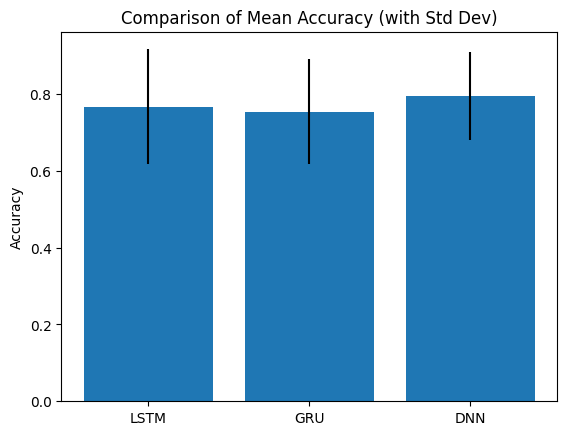

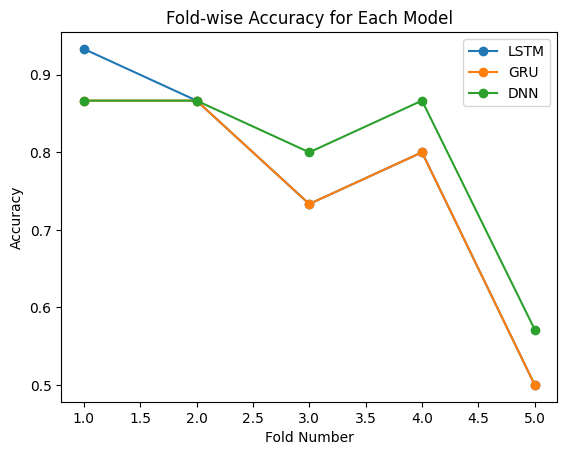

In [ ]:
#? Std as black error bars
compare_model_results(
    results_dicts=[results_lstm, results_gru, results_dnn],
    model_labels=["LSTM", "GRU", "DNN"]
)

### 7.2 Plot n fold, to evaluate training and validation result

In [ ]:
import matplotlib.pyplot as plt

def plot_fold_history(fold_history, fold_num=1, title_name=""):
	"""
	Plots accuracy and loss side by side for a single fold's training process.
	
	Parameters:
		fold_history (dict): Dictionary with keys 'accuracy', 'val_accuracy', 'loss', 'val_loss'
		fold_num (int): Fold index (for title labeling)
		title_name (str): Add title name
	"""
	# Extract metrics
	train_acc = fold_history.get('accuracy', [])
	val_acc = fold_history.get('val_accuracy', [])
	train_loss = fold_history.get('loss', [])
	val_loss = fold_history.get('val_loss', [])

	epochs_range = range(1, len(train_acc) + 1)

	# print final accurary and loss
	print(f"Fold {fold_num} - Train Accuracy: {train_acc[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")

	# Create side-by-side subplots
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
	
	# Accuracy subplot
	ax1.plot(epochs_range, train_acc, label='Train Accuracy')
	ax1.plot(epochs_range, val_acc, label='Val Accuracy')
	ax1.set_title(f'Fold {fold_num} - Accuracy - {title_name}')
	ax1.set_xlabel('Epoch')
	ax1.set_ylabel('Accuracy')
	ax1.legend()

	# Loss subplot
	ax2.plot(epochs_range, train_loss, label='Train Loss')
	ax2.plot(epochs_range, val_loss, label='Val Loss')
	ax2.set_title(f'Fold {fold_num} - Loss - {title_name}')
	ax2.set_xlabel('Epoch')
	ax2.set_ylabel('Loss')
	ax2.legend()

	plt.tight_layout()
	plt.show()


Fold 2 - Train Accuracy: 0.7288, Val Accuracy: 0.6667


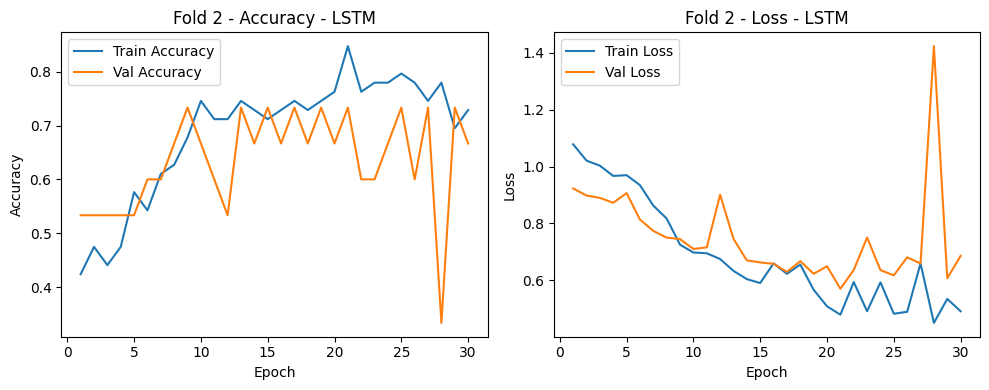

Fold 2 - Train Accuracy: 0.7966, Val Accuracy: 0.7333


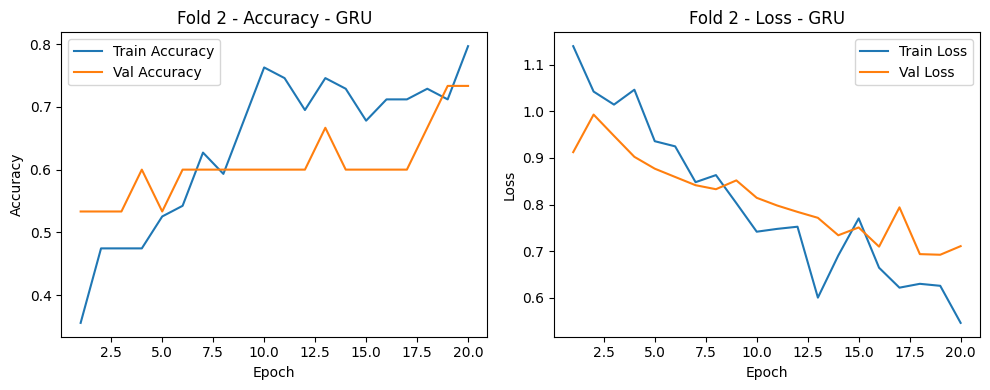

Fold 2 - Train Accuracy: 0.8305, Val Accuracy: 0.8000


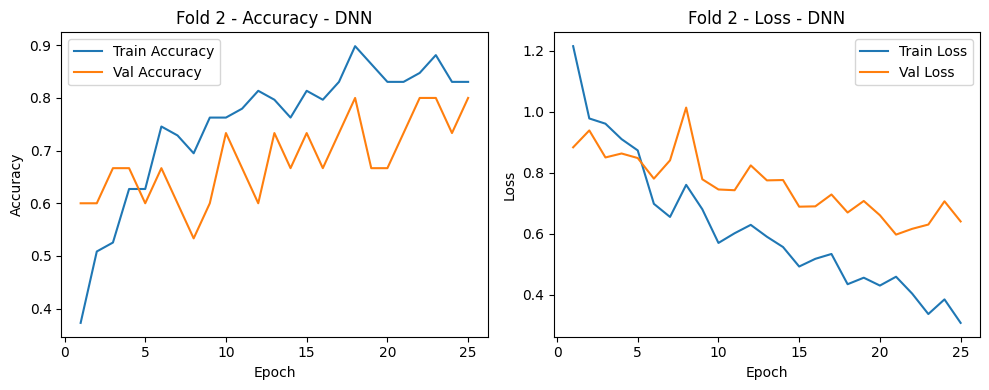

In [ ]:
fold_num = 2 #? 5 fold: 0 to 4
fold_histories = results_lstm["fold_histories"]
plot_fold_history(fold_histories[fold_num], fold_num=fold_num, title_name="LSTM")

fold_histories = results_gru["fold_histories"]
plot_fold_history(fold_histories[fold_num], fold_num=fold_num, title_name="GRU")

fold_histories = results_dnn["fold_histories"]
plot_fold_history(fold_histories[fold_num], fold_num=fold_num, title_name="DNN")
# Or loop over all folds
# for i, fh in enumerate(fold_histories):
#     plot_fold_history(fh, fold_num=i+1)

### Plot Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices_for_fold(
    fold,
    results_dicts,
    model_names,
    class_names
):
    """
    Plots confusion matrices of multiple models side by side for the same fold.

    Parameters:
        fold (int): Fold number to visualize (1-based index)
        results_dicts (list): List of results (each with "confusion_matrices")
        model_names (list): List of model names (e.g., ["LSTM", "GRU", "DNN"])
        class_names (list): List of class labels
    """
    num_models = len(results_dicts)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

    for idx, (results, model_name) in enumerate(zip(results_dicts, model_names)):
        cm = results["confusion_matrices"][fold - 1]  # 0-based index
        ax = axes[idx] if num_models > 1 else axes  # Handle case when only 1 model

        im = ax.imshow(cm, cmap='Blues')
        ax.set_title(f"{model_name} - Fold {fold}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        tick_marks = np.arange(len(class_names))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(class_names, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(class_names)

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, str(cm[i, j]),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    fig.tight_layout()
    plt.show()

C:\Users\boboi\AppData\Local\Temp\ipykernel_18412\2506742204.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


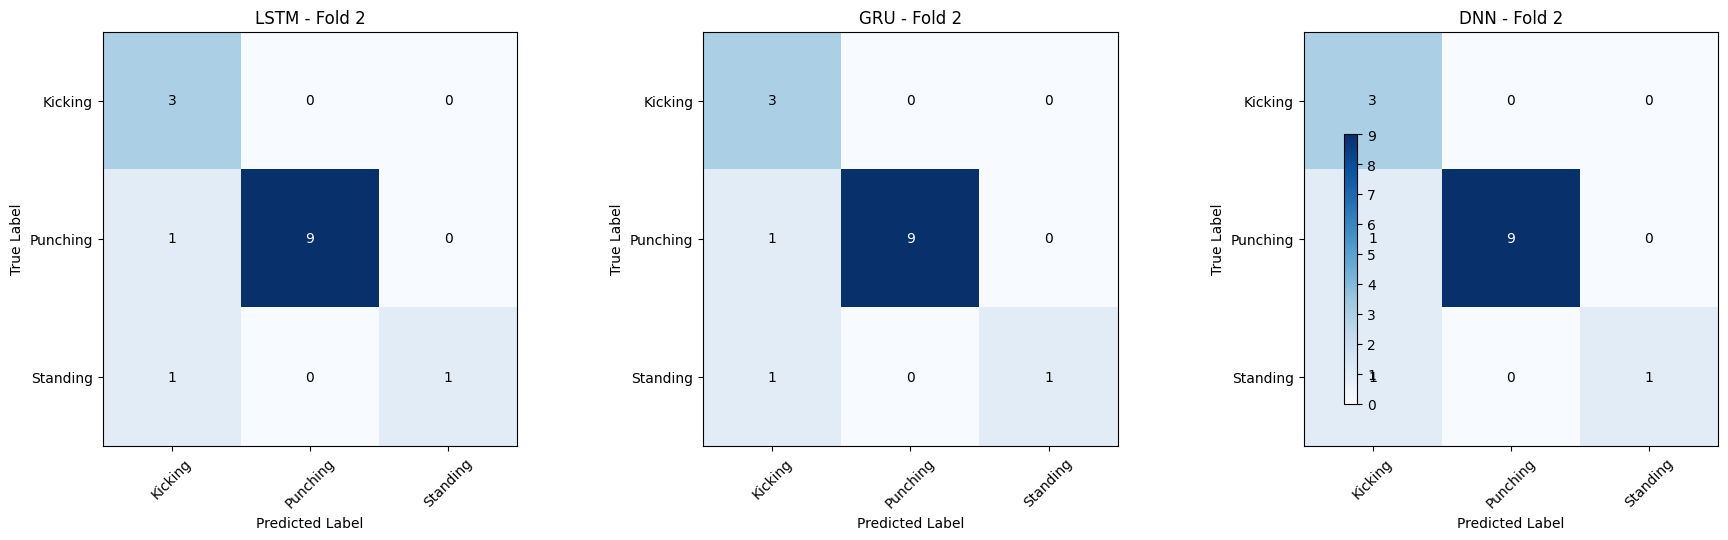

In [ ]:
plot_confusion_matrices_for_fold(
    fold=2,  # Choose which fold to visualize (1-based index)
    results_dicts=[results_lstm, results_gru, results_dnn],
    model_names=["LSTM", "GRU", "DNN"],
    class_names=CLASSES
)


In [ ]:
def plot_model_confusion_matrices(confusion_matrices, class_names, model_name="Model", save=False):
    """
    Plots all confusion matrices from k-fold for a single model.

    confusion_matrices: list of cm from results["confusion_matrices"]
    class_names: list of action labels
    model_name: "LSTM", "GRU", etc.
    """
    for fold_idx, cm in enumerate(confusion_matrices, start=1):
        plot_confusion_matrix(
            cm, 
            class_names, 
            title=f"{model_name} Confusion Matrix", 
            fold=fold_idx
        )

In [ ]:
# plot_model_confusion_matrices(results_lstm["confusion_matrices"], CLASSES, model_name="LSTM", save=True)
# plot_model_confusion_matrices(results_gru["confusion_matrices"], CLASSES, model_name="GRU", save=True)
# plot_model_confusion_matrices(results_dnn["confusion_matrices"], CLASSES, model_name="DNN", save=True)

### Plot Precision and Recall

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score

def plot_precision_per_model_fold(fold, results_dicts, model_names, class_names):
    """
    Plot precision per class for each model, for a specific fold.

    Parameters:
        fold (int): Fold number to visualize (1-based index)
        results_dicts (list): List of result dicts from kfold_validation()
        model_names (list): Corresponding list of model names (e.g., ["LSTM", "GRU", "DNN"])
        class_names (list): Names of the action classes (e.g., ["Kicking", "Punching", "Non-violent"])
    """
    fold_idx = fold - 1  # Convert to 0-based index
    num_models = len(results_dicts)
    num_classes = len(class_names)
    
    fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 8), sharey='row')

    if num_models == 1:
        axes = [[axes], [axes]]

    for i, (results, model_name) in enumerate(zip(results_dicts, model_names)):
        cm = results["confusion_matrices"][fold_idx]

        # Precision per class: TP / (TP + FP)
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        precision = tp / np.maximum(tp + fp, 1)  # Avoid division by zero

        # Recall per class: TP / (TP + FN)
        fn = np.sum(cm, axis=1) - tp
        recall = tp / np.maximum(tp + fn, 1)  # Avoid division by zero
        
        # Precision Plot
        ax_precision = axes[0, i]
        ax_precision.bar(class_names, precision, color='skyblue')
        ax_precision.set_title(f"{model_name} - Fold {fold} - Precision")
        ax_precision.set_ylabel("Precision")
        ax_precision.set_ylim(0, 1.0)
        ax_precision.set_xticklabels(class_names, rotation=45)

        for j, val in enumerate(precision):
            ax_precision.text(j, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)
            
        # Recall Plot
        ax_recall = axes[1, i]
        ax_recall.bar(class_names, recall, color='lightcoral')
        ax_recall.set_title(f"{model_name} - Fold {fold} - Recall")
        ax_recall.set_ylabel("Recall")
        ax_recall.set_ylim(0, 1.0)
        ax_recall.set_xticklabels(class_names, rotation=45)

        for j, val in enumerate(recall):
            ax_recall.text(j, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

C:\Users\boboi\AppData\Local\Temp\ipykernel_18412\3208390643.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_precision.set_xticklabels(class_names, rotation=45)
C:\Users\boboi\AppData\Local\Temp\ipykernel_18412\3208390643.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_recall.set_xticklabels(class_names, rotation=45)
C:\Users\boboi\AppData\Local\Temp\ipykernel_18412\3208390643.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_precision.set_xticklabels(class_names, rotation=45)
C:\Users\boboi\AppData\Local\Temp\ipykernel_18412\3208390643.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_recall.set_xticklabels(class_names, rotatio

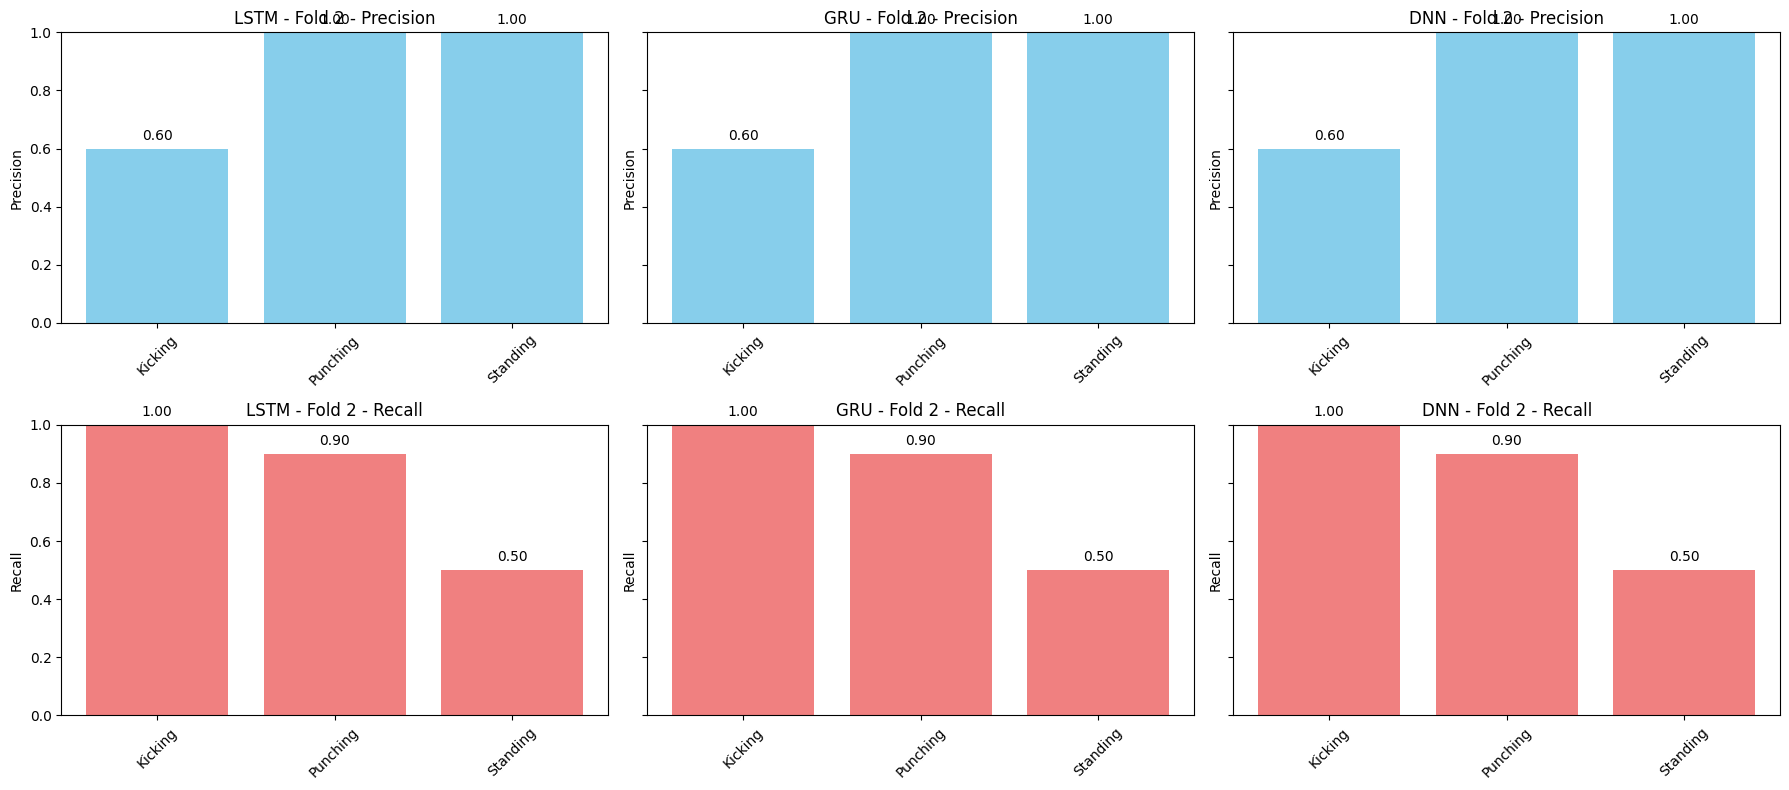

In [ ]:
plot_precision_per_model_fold(
    fold=2,
    results_dicts=[results_lstm, results_gru, results_dnn],
    model_names=["LSTM", "GRU", "DNN"],
    class_names=CLASSES
)

In [ ]:
import os
import glob

BASE_DIR = "Single_person_violent"
KICKING_DIR = os.path.join(BASE_DIR, "Punching")

# Use glob to list all .mp4 or .avi files in the Kicking directory
video_paths = glob.glob(os.path.join(KICKING_DIR, "*.mp4")) + glob.glob(os.path.join(KICKING_DIR, "*.avi"))

num_videos = len(video_paths)
print(f"Total number of videos in the 'Single_person_violent/Kicking' folder: {num_videos}")

Total number of videos in the 'Single_person_violent/Kicking' folder: 35


# 5. Make Detection

In [ ]:
import collections

lstm_path = "lstm_model.h5"
gru_path = "gru_model.h5"
dnn_pth = "dnn_model.h5"

#Load model
lstm_infer_model = tf.keras.models.load_model(lstm_path)
gru_infer_model = tf.keras.models.load_model(gru_path)
dnn_infer_model = tf.keras.models.load_model(dnn_pth)

infer_model = dnn_infer_model

In [ ]:
# Define global constants
CLASSES = ["Kicking", "Punching", "Standing"]
MAX_SEQ_LEN = 5
NUM_FEATURES = 132  # 33 keypoints * (x, y, z, visibility)

In [ ]:
import cv2 as cv
import numpy as np
import mediapipe as mp
import collections
import tensorflow as tf



# Set up MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Buffer to store latest MAX_SEQ_LEN frames of keypoints
buffer = collections.deque(maxlen=MAX_SEQ_LEN)


# Start webcam
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to consistent shape (optional for clarity)
    frame = cv.resize(frame, (960, 720))

    # Convert to RGB and get pose
    rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    results = pose.process(rgb)

    # Extract pose keypoints
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
    else:
        keypoints = [0] * NUM_FEATURES

    # Add keypoints to buffer
    buffer.append(keypoints)

    if len(buffer) == MAX_SEQ_LEN:
        seq = np.array(buffer)

        if infer_model == dnn_infer_model:
            seq_input = seq.reshape(1, -1)  # DNN input shape: (1, 660)
        else:
            seq_input = np.expand_dims(seq, axis=0)  # LSTM/GRU input shape: (1, 5, 132)

        pred = infer_model.predict(seq_input, verbose=0)
        class_id = np.argmax(pred)
        confidence = float(pred[0][class_id]) * 100
        class_name = CLASSES[class_id]
        
        if class_name == "Standing":
            display_text = f"{class_name} ({confidence:.1f}%), Non-Violent"
        else:
            display_text = f"{class_name} ({confidence:.1f}%), Violent"
            
            
        # Show prediction on frame
        cv.putText(frame, f'Action: {display_text}', (30, 50),
                   cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    else:
        display_text = "Non-Violent"
        cv.putText(frame, f'Action: {display_text}', (30, 50),
                   cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # Draw pose landmarks
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

    # Display the frame
    cv.imshow("Live Action Detection", frame)

    # Press 'q' to exit
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv.destroyAllWindows()
pose.close()


### Test on Video

In [ ]:
# Use the test_video_paths that's already defined in the context
test_video_path = "Single_person_violent\Kicking\kicking23.avi"
# test_video_path = "A-Dataset-for-Automatic-Violence-Detection-in-Videos\\violence-detection-dataset\\violent\cam1\\1.mp4" 
print(f"Processing: {os.path.basename(test_video_path)}")

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)

# Open video file
cap = cv.VideoCapture(test_video_path)

# Buffer to store latest MAX_SEQ_LEN frames of keypoints
buffer = collections.deque(maxlen=MAX_SEQ_LEN)

while True:
	ret, frame = cap.read()
	if not ret:
		break

	# Convert to RGB and get pose
	rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
	results = pose.process(rgb)

	# Extract pose keypoints
	if results.pose_landmarks:
		keypoints = []
		for lm in results.pose_landmarks.landmark:
			keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
	else:
		keypoints = [0] * NUM_FEATURES

	# Add keypoints to buffer
	buffer.append(keypoints)

	if len(buffer) == MAX_SEQ_LEN:
		seq = np.array(buffer)

		if infer_model == dnn_infer_model:
			seq_input = seq.reshape(1, -1)  # DNN input shape: (1, 660)
		else:
			seq_input = np.expand_dims(seq, axis=0)  # LSTM/GRU input shape: (1, 5, 132)

		pred = infer_model.predict(seq_input, verbose=0)
		class_id = np.argmax(pred)
		confidence = float(pred[0][class_id]) * 100
		class_name = CLASSES[class_id]

		if class_name == "Standing":
			display_text = f"{class_name} ({confidence:.1f}%), Non-Violent"
		else:
			display_text = f"{class_name} ({confidence:.1f}%), Violent"

		# Show prediction on frame
		cv.putText(frame, f'Action: {display_text}', (30, 50),
				   cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

	# Draw pose landmarks
	if results.pose_landmarks:
		mp.solutions.drawing_utils.draw_landmarks(
			frame,
			results.pose_landmarks,
			mp_pose.POSE_CONNECTIONS,
			landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
			connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
		)

	# Display the frame
	cv.imshow(f"Action Detection - {os.path.basename(test_video_path)}", frame)

	# Press 'q' to exit
	if cv.waitKey(1) & 0xFF == ord('q'):
		break

# Cleanup
cap.release()
cv.destroyAllWindows()
pose.close()

Processing: kicking23.avi
